In [1]:
import pandas as pd
import numpy as np

# change the display width to see all columns
pd.set_option('display.width', 500)

games_df = pd.read_csv('./data/games.csv', low_memory=False)
games_details_df = pd.read_csv('./data/games_details.csv', low_memory=False)
# players_df = pd.read_csv('./data/players.csv')
ranking_df = pd.read_csv('./data/ranking.csv')
teams_df = pd.read_csv('./data/teams.csv')

Clean the game dataframe and group by season

In [2]:
games_df = games_df.drop(columns=['GAME_STATUS_TEXT'])

games_df.groupby(['SEASON'])
games_df = games_df.sort_values('GAME_DATE_EST')

print(games_df.head(200))

      GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS
19288    2003-10-05  10300001    1610612762       1610612742    2003    1610612762      90.0        0.457        0.735         0.143      23.0      41.0    1610612742      85.0        0.447        0.500         0.250      20.0      38.0               1
19287    2003-10-06  10300002    1610612763       1610612749    2003    1610612763     105.0        0.494        0.618         0.267      25.0      48.0    1610612749      94.0        0.427        0.700         0.154      20.0      43.0               1
19280    2003-10-07  10300010    1610612764       1610612752    2003    1610612764     104.0        0.506        0.677         0.455      26.0      45.0    1610612752      86.0        0.380        0.852         0.188      19.0      37.0     

Below we will create the ELO rating for each team, as a default the team will start with 1500 points. Each time a team wins or loses a game, the ELO rating will be updated. The ELO rating will be updated based on the following formula:



Updated Team ELO = Team ELO + k * (Team Expected Outcome - Team Actual Outcome)

In [3]:
initial_elo = 1500
k_factor = 20
team_elos = {team_id: initial_elo for team_id in pd.concat([games_df['HOME_TEAM_ID'], games_df['VISITOR_TEAM_ID']]).unique()}


def expected_outcome(home_elo, away_elo):
    return 1 / (1 + 10 ** ((away_elo - home_elo) / 400))

def update_elo(home_elo, visitor_elo, home_win, k=20):
    expected_home_win = expected_outcome(home_elo, visitor_elo)
    actual_home_win = 1 if home_win else 0
    new_home_elo = home_elo + k * (actual_home_win - expected_home_win)
    new_visitor_elo = visitor_elo + k * ((1 - actual_home_win) - (1 - expected_home_win))
    return new_home_elo, new_visitor_elo


After iterating, team_elos will have the updated Elo ratings for each team

In [4]:
for index, row in games_df.iterrows():
    home_team, away_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    home_elo, away_elo = team_elos[home_team], team_elos[away_team]
    home_win = row['HOME_TEAM_WINS']
    new_home_elo, new_away_elo = update_elo(home_elo, away_elo, home_win)
    team_elos[home_team], team_elos[away_team] = new_home_elo, new_away_elo
    

Group each Season into its own dataframe, this will help for calculating the overall ELO rating for each team in a season. I can then also track the ELO rating for each team over time, and see how it changes over the course of the dataset.

In [5]:
seasons_df = games_df.groupby('SEASON')
seasons_dict = {}
for season, season_df in seasons_df:
    seasons_dict[season] = season_df

# Iterate over the dictionary and calculate the percentage of missing values
for season, season_df in seasons_dict.items():
    missing_values_percent = season_df.isnull().sum() * 100 / len(season_df)
    print(f"Percentage of missing values for season {season}:")
    print(missing_values_percent)

Percentage of missing values for season 2003:
GAME_DATE_EST      0.000000
GAME_ID            0.000000
HOME_TEAM_ID       0.000000
VISITOR_TEAM_ID    0.000000
SEASON             0.000000
TEAM_ID_home       0.000000
PTS_home           7.148014
FG_PCT_home        7.148014
FT_PCT_home        7.148014
FG3_PCT_home       7.148014
AST_home           7.148014
REB_home           7.148014
TEAM_ID_away       0.000000
PTS_away           7.148014
FG_PCT_away        7.148014
FT_PCT_away        7.148014
FG3_PCT_away       7.148014
AST_away           7.148014
REB_away           7.148014
HOME_TEAM_WINS     0.000000
dtype: float64
Percentage of missing values for season 2004:
GAME_DATE_EST      0.0
GAME_ID            0.0
HOME_TEAM_ID       0.0
VISITOR_TEAM_ID    0.0
SEASON             0.0
TEAM_ID_home       0.0
PTS_home           0.0
FG_PCT_home        0.0
FT_PCT_home        0.0
FG3_PCT_home       0.0
AST_home           0.0
REB_home           0.0
TEAM_ID_away       0.0
PTS_away           0.0
FG_PCT_away

Here each team's ELO will be saved in a dataframe then merged with the team dataframe to get the ELO rating for each team in the dataset. 

In [6]:
team_elos_df = pd.DataFrame.from_dict(team_elos, orient='index', columns=['ELO'])
team_elos_df = team_elos_df.merge(teams_df, left_index=True, right_on='TEAM_ID')
team_elos_df = team_elos_df.sort_values('ELO', ascending=False)


In [11]:
# Create margin of victory column
games_df["MOV"] = games_df["PTS_home"] - games_df["PTS_away"]
close_games = games_df[(games_df["MOV"] > -5) & (games_df["MOV"] < 5)]
print('Number of close games:', close_games.shape[0])

close_game_prob = close_games["MOV"].count() / games_df["MOV"].count()*100
print('Probability of a close game:', close_game_prob)

Number of close games: 5631
Probability of a close game: 21.20744200060259


In [8]:
# Create high scoring game column
games_df["total_score"] = games_df["PTS_home"] + games_df["PTS_away"]
high_scoring_games = games_df[games_df["total_score"] > 220]
print('Number of high scoring games:', high_scoring_games.shape[0])

high_scoring_game_prob = len(high_scoring_games) / len(games_df)*100
print('Probability of a high scoring game:', high_scoring_game_prob)

Number of high scoring games: 6258
Probability of a high scoring game: 23.48129526096582


ValueError: x and y must have same first dimension, but have shapes (24,) and (22,)

<Figure size 640x480 with 0 Axes>

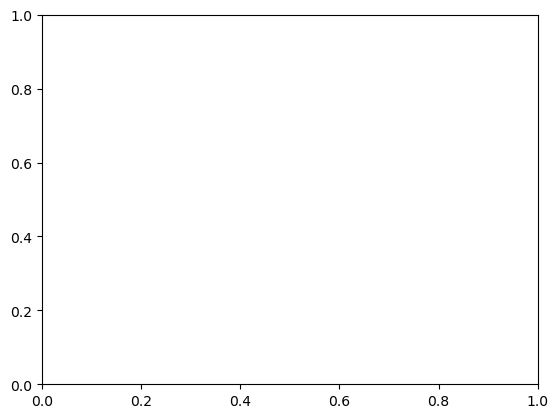

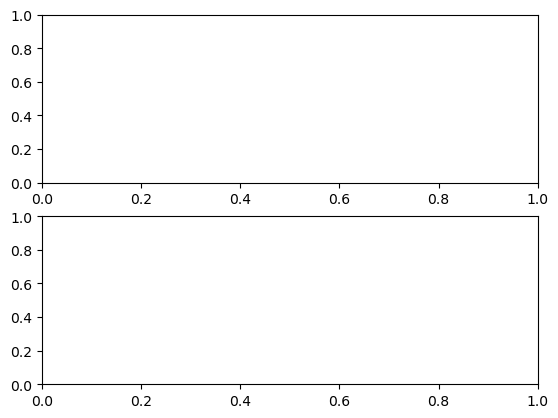

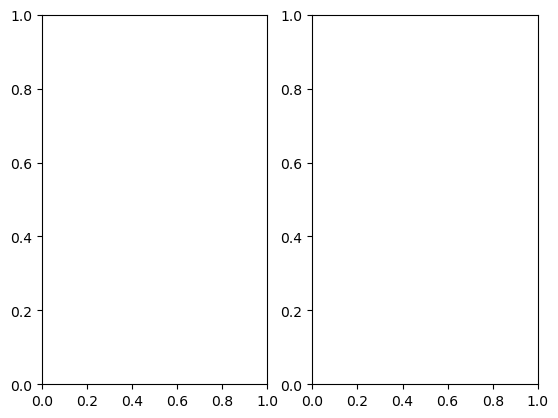

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax = plt.subplots()
fig, axs = plt.subplots(2, 1)
fig, axs = plt.subplot_mosaic([['close_games', 'high_scoring_games']])
high_scoring_games = np.arange(high_scoring_game_prob)
close_games = np.arange(close_game_prob)
axs.plot(high_scoring_games, close_games, label='High Scoring Games')


Below is a rough outline of the final recommender system that I will be building in this notebook. It takes in the schedule for upcoming games, and outputs the recommended games that will be the closest and most exciting to watch based on the historical data from NBA games.

In [9]:
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import f1_score

# # Load the trained model
# model = NearestNeighbors(n_neighbors=5, metric='cosine')
# model.load('nba_game_recommender.pkl')

# # Load the schedule for the upcoming night's games
# schedule = pd.read_csv('nba_schedule.csv')

# # Extract relevant features for each game
# features = []
# for index, row in schedule.iterrows():
#     game_id = row['Game_ID']
#     home_team = row['Home_Team']
#     away_team = row['Away_Team']
#     # Extract features from historical data
#     feature_vector = get_features(game_id, home_team, away_team)
#     features.append(feature_vector)

# # Use the model to predict the most exciting game(s) to watch
# distances, indices = model.kneighbors(features)
# recommended_games = []
# for i, dist in enumerate(distances):
#     if dist < 0.5:  # Arbitrarily set a threshold